### Imports:

In [1]:
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
from matplotlib import pyplot as plt
import time
import os
import numpy as np
import re
import pandas as pd
import webbrowser 
import textwrap
import math
from tkinter import *
from tkinter import ttk
from tqdm.notebook import tqdm

import nltk
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.cluster import KMeans 

### Install a pretrained sentence transformers model:

In [9]:
# From https://huggingface.co/sentence-transformers/all-mpnet-base-v2
model = SentenceTransformer('all-mpnet-base-v2')

### Directories for scraped and processed texts:

In [3]:
scraped_texts_dir = 'scraped_texts'
processed_texts_dir = 'processed_texts'
os.makedirs(scraped_texts_dir, exist_ok=True)
os.makedirs(processed_texts_dir, exist_ok=True)

### Webscraping:

In [10]:
# Returns the preprint containers (with the preprint title, link, author names) from the search page
def read_search_page(url):
    uClient = uReq(url)
    page_html = uClient.read()
    uClient.close()
    page_soup = soup(page_html, 'html.parser')
    containers = page_soup.findAll('div', {'class':'highwire-cite highwire-cite-highwire-article highwire-citation-biorxiv-article-pap-list clearfix'})
    return containers

# Returns the number of results from the search page
def get_num_results():
    search_term = searchfield.get()
    search_term = search_term.split(' ')
    search_term = '%252B'.join(search_term)
    site = sites.get()
    first_part = 'https://www.' + site + '.org/search/'
    search_url = first_part + search_term + '%20numresults%3A10%20sort%3Apublication-date%20direction%3Adescending' 
    ########################################################################################
    #search_url = 'some other url here' #if you would like to input a full custom search url
    ########################################################################################
    uClient = uReq(search_url)
    page_html = uClient.read()
    uClient.close()
    page_soup = soup(page_html, 'html.parser')
    
    num = re.findall(r'\d+',page_soup.h1.text.strip())
    if num:
        num_results = int(''.join(num))
        l3_string.set(str(num_results) + ' results found. Retrieve papers? Sorted by newest to oldest.')   
        max_results = []
        for pages in range(math.ceil(num_results/10)):
            if (pages+1) == (math.ceil(num_results/10)):
                max_results.append(str((pages)*10+num_results % 10) + ' max results')
            else:
                max_results.append(str((pages+1)*10) + ' max results')

        maxresults['values'] = max_results
        maxresults.grid(row = 1, column = 6, sticky = E, pady = 2) 
        collectbtn.grid(row = 1, column = 7, sticky = E, pady = 2)
        
    else:
        l3_string.set('No results found')
        maxresults.grid_forget()
        collectbtn.grid_forget()
    return num_results

# Returns text from a preprint page
def read_article_page(url): 
    uClient = uReq(url+'.full')
    page_html = uClient.read()
    uClient.close()
    page_soup = soup(page_html, 'html.parser')

    date = page_soup.findAll('div',{'class':'panel-pane pane-custom pane-1'})[0].div.text.strip()
    date = re.sub('\.','',date[7:])
    
    article_soup = page_soup.find_all('div',{'class':re.compile('^article ')})[0]

    for toremove in article_soup.find_all(id=[re.compile('^F\d'),(re.compile('^T\d'))]):
        toremove.decompose()
    for toremove in article_soup.find_all('a',{'class':'xref-bibr'}):
        toremove.decompose()
    for toremove in article_soup.find_all('a',{'class':'xref-fig'}):
        toremove.decompose()
    for toremove in article_soup.find_all('sup'):
        toremove.decompose()

    main_titles = []
    subtitles = []
    curr_section = []

    abstract = []
    introduction = []
    results = []
    methods = []
    discussion = []
    
    intro = False
    for title in article_soup.find_all('h2'):
        if ('introduction' in (title.text).lower()) | ('main' in (title.text).lower()):
            intro = True # for dealing with labeling inconsistencies for introduction sections

    for tag in article_soup.find_all(True):
        if (re.match('^h', tag.name)):
            if tag.name == 'h2':
                main_titles.append(tag.text.lower())
                curr_section = tag.text.lower()
            else:
                subtitles.append(tag.text.lower())
        if (re.match('^p', tag.name)):
            if ('abstract' in curr_section) | ('summary' in curr_section):
                if (intro == False) & (len(abstract)>0):  # sometimes abstracts go straight into introductions
                    introduction += [tag.text.strip()]
                else:
                    abstract += [tag.text.strip()]
            if ('introduction' in curr_section) | ('main' in curr_section):
                introduction += [tag.text.strip()]
            if 'results' in curr_section:
                results += [tag.text.strip()]
            if 'methods' in curr_section:
                methods += [tag.text.strip()]
            if 'discussion' in curr_section:
                discussion += [tag.text.strip()]        
    return abstract, introduction, results, methods, discussion, date

# Goes into each container from the search page and gets text from each preprint page
def get_papers(search_url, filename, max_pages):
    uClient = uReq(search_url)
    page_html = uClient.read()
    uClient.close()
    page_soup = soup(page_html, 'html.parser')   
    num_pages = max_pages
    page_num = 0

    title = []
    authors = []
    date = []
    paper_url = []

    while page_num < num_pages:
        if page_num == 0:
            page_url = search_url

        else:
            page_url = search_url + '?page=' + str(page_num)

        for container in read_search_page(page_url):
            result_url = 'https://www.biorxiv.org' + container.a['href']  
            paper_url.append(result_url)
            title.append(container.a.span.text)
            result_authors = container.findAll('span', {'class':'highwire-citation-authors'})[0].text
            authors.append(result_authors)

        page_num += 1

    abstract = []
    introduction = []
    methods = []
    results = []
    discussion = []
    
    num_urls = len(paper_url)
    progress1 = ttk.Progressbar(topleftframe, orient = HORIZONTAL, length=100, mode = 'determinate')
    progress1.grid(row = 1, column = 8, sticky = E, pady = 2) 
    i = 1
    
    for url in tqdm(paper_url):
        progress1["value"] = i*100/num_urls
        l3_string.set(f'Scraping paper {i} of {num_urls}')
        root.update()
        i += 1   
        
        abst, intr, rslt, methd, disc, dt = read_article_page(url)
        abstract += [abst]
        introduction += [intr]
        results += [rslt]
        methods += [methd]
        discussion += [disc]
        date += [dt]          
        
    progress1.grid_remove()
    df = pd.DataFrame(list(zip(title, authors, date, paper_url, abstract, introduction, results, methods, discussion)),
                          columns = ['Title','Authors','Date','Paper Url','Abstract', 'Introduction', 'Results', 'Methods', 'Discussion'])

    
    return df

### For processing articles:

In [5]:
# Returns the most average sentence (or sentences) in a block of text along with an averaged out embedding for the text
def return_average_sentences(text, num_returned=1):
    returned = num_returned
    sentences = nltk.tokenize.sent_tokenize(text)  
    embeds = model.encode(sentences)
    avg = sum(embeds) / len(embeds)    
    cosim = cosine_similarity([avg], embeds)   
    average_sentences = [sentences[idx] for idx in cosim.argsort()[0][-returned:]]

    return average_sentences, avg

# Clusters preprints based their most average sentence embeddings
def cluster_papers(dataframe):
    X = dataframe['Average Embedding'].tolist()
    k_rng = range(1,int(len(X)))
    sse = []
    for k in k_rng:
        km = KMeans(n_clusters=k)
        km.fit(X)
        sse.append(km.inertia_)

    plt.xlabel('K')
    plt.ylabel('Sum of squared error')
    plt.plot(k_rng, sse)

    # Automatic quick elbow method; just picks the point with the longest distance away from the line between the two most outer points
    x1 = k_rng[0]
    y1 = sse[0]
    x2 = k_rng[-1]
    y2 = sse[-1]

    x = [x1, x2]
    y = [y1, y2]
    coefficients = np.polyfit(x, y, 1)
    polynom = np.poly1d(coefficients)
    x = np.array(k_rng)
    y = polynom(x)
    plt.plot(x, y)

    p1 = np.array([x1, y1])
    p2 = np.array([x2, y2])
    distance = []

    candidate_points = []

    for x, y in zip(k_rng, sse):
        p3 = [x, y]
        d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
        candidate_points.append(p3)
        distance.append(d)

    num_clusters = np.argsort(distance)[-1]
    point = candidate_points[num_clusters]

    print('Num clusters: ' + str(num_clusters))
    plt.plot(point[0], point[1], 'rp', markersize=10)
    plt.show()
    
    
    # Adds the clusters as well as center clusters to the dataframe
    km = KMeans(n_clusters=num_clusters)
    y_predicted = km.fit_predict(X)
    centers = km.cluster_centers_

    dataframe['Cluster'] = y_predicted
    dataframe['Centers'] = dataframe['Cluster'].apply(lambda x: centers[x])

    dataframe = dataframe.sort_values('Cluster')

    return dataframe

# Returns the average sentences and embeddings for each article
def process_articles(dataframe):
    abbreviated_texts = []
    average_sentences = []
    average_embeddings = []
    keywords = []

    num_articles = dataframe.shape[0]
    progress2 = ttk.Progressbar(topleftframe, orient = HORIZONTAL, length=100, mode = 'determinate')
    progress2.grid(row = 1, column = 8, sticky = E, pady = 2) 
    progress_idx = 1
        
    with tqdm(total=num_articles) as pbar: 
        for row in dataframe.itertuples(index=True):
            pbar.update(1)
            text = row[5:10]
            merged_text = []
            abbreviated_article = []
            progress2["value"] = progress_idx*100/num_articles
            l3_string.set(f'Processing paper {progress_idx} of {num_articles}')
            root.update()
            progress_idx += 1

            for i, section in enumerate(text):
                section_avg_sentences = []
                for j, paragraph in enumerate(section):
                    if paragraph:
                        paragraph = re.sub(' \([^)]*\)', '', paragraph) 
                        paragraph = re.sub(' \[.*?\]', '', paragraph) #for removing brackets and parentheses (and text in between)
                        para_avg_sentence, _ = return_average_sentences(paragraph)                
                        merged_text.append(paragraph)                
                        section_avg_sentences.append(para_avg_sentence[0])
                abbreviated_article.append(section_avg_sentences)
            abbreviated_texts.append(abbreviated_article)
            merged_text = ' '.join(merged_text)
            keywords_article = get_keywords([merged_text])
            keywords.append(keywords_article)
            sentence, average_embed = return_average_sentences(merged_text)
            average_sentences.append(sentence) 
            average_embeddings.append(average_embed)
            
            
    dataframe['Average Text'] = abbreviated_texts
    dataframe['Average Sentence'] = average_sentences
    dataframe['Average Embedding'] = average_embeddings
    dataframe['Keywords'] = keywords
    
    progress2.grid_remove()
    return dataframe


# Returns keywords from a text; largely from: https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea
def get_keywords(text):
    n_gram_range = (1, 1)
    returned = 5
        
    count = CountVectorizer(ngram_range=n_gram_range, stop_words='english').fit(text)
    words = count.get_feature_names()
    gen_embedding = model.encode(text)
    word_embeddings = model.encode(words)
    cosim = cosine_similarity(gen_embedding, word_embeddings)
    keywords = [words[idx] for idx in cosim.argsort()[0][-returned:]]
    return keywords

# Returns keywords for each cluster
def get_cluster_keywords(dataframe):
    cluster_keywords = []
    clusters = dataframe['Cluster'].unique()
    for cluster in clusters:
        cluster_text = []
        for sentence in dataframe['Average Sentence'][dataframe.Cluster==cluster]:
            cluster_text.append(sentence[0])
        keywords = get_keywords(cluster_text)
        cluster_keywords.append(keywords)
    dataframe['Cluster Keywords'] = dataframe['Cluster'].apply(lambda x: cluster_keywords[x])
    
    return dataframe

# Sorts the dataframe by proximity to a center cluster, and then by cluster
def cluster_center_sort(dataframe):
    center_proximity = []
    clusters = dataframe['Cluster'].unique()
    for cluster in clusters:
        cluster_embeddings = []
        cluster_center = (dataframe['Centers'][dataframe.Cluster==cluster].tolist())[0]
        for embedding in dataframe['Average Embedding'][dataframe.Cluster==cluster]:
            cluster_embeddings.append(embedding)
        order = range(0, len(embedding-1))
        cosim = cosine_similarity([cluster_center], cluster_embeddings)
        center_proximity = np.concatenate((center_proximity, *cosim))
    dataframe['Center Proximity'] = center_proximity
    
    dataframe = dataframe.sort_values(['Center Proximity'], ascending=False)
    dataframe = dataframe.sort_values(['Cluster'])
    
    return dataframe

### Sets up text scraping and processing:

In [6]:
def rxiv_search(search_url, filename, max_results):
    start_time = time.time()
    
    ################################################################
    max_pages = math.ceil(max_results/10)
    
    print('Scraping papers')   
    df = get_papers(search_url, filename, max_pages)    
    df.to_excel('scraped_texts/'+filename+'.xlsx', index=False)
    
    ##############################################################
    print('Processing papers')

    df = process_articles(df)
    df = cluster_papers(df)  
    df = get_cluster_keywords(df)    
    df = cluster_center_sort(df)
    
    if not os.path.exists('processed_texts/'):
        os.makedirs('processed_texts/')
    
    #df.to_excel('processed_texts/'+filename+'.xlsx', index=False)
    df.to_pickle('processed_texts/'+filename+'.df')
    
    end_time = time.time() 
    duration = (end_time-start_time)
    duration = round(duration, 2)
    time_unit = ' seconds'
    if duration > 60:
        time_unit = ' minutes'
        duration = duration/60 
        
    duration = round(duration, 1)
    duration = str(duration) + time_unit
    num_results = len(df)

    print('Retrieval complete. Total time: ' + duration)
       
    return df, duration

### Functions for the GUI:

In [7]:
# Wraps text
def wrap(string, length=8):
    return '\n'.join(textwrap.wrap(string, length))

# Returns a shortened list of author names
def abbrev_names(names):
    abbrvnames = ''
    if len(names) == 3:
        abbrvnames = abbrev_name(names[0]) + ', ' + abbrev_name(names[1]) + ', and ' + abbrev_name(names[2])
    if len(names) == 2:
        abbrvnames = abbrev_name(names[0]) + ', and ' + abbrev_name(names[1])
    if len(names) == 1:
        abbrvnames = abbrev_name(names[0])
    else:
        abbrvnames = abbrev_name(names[0]) + ' et al.'
    return abbrvnames

def abbrev_name(name):
    abbrvname = name.split(' ')
    surname = abbrvname[-1]
    givennames = ' '.join(abbrvname[:-1])
    abbrvname = ''.join(re.findall('[A-Z]', givennames)) + ' ' + surname
    return abbrvname

# Opens a browser link for the preprint
def on_web_click(event):
    url = url_string.get()
    webbrowser.open(url)

# Puts summarized (shortened) text for a preprint on the right of the window
def on_double_click(event):
    item_id = event.widget.focus()
    item = event.widget.item(item_id)
    values=item['values']
    title=' '.join((values[3]).split('\n'))
    authors=values[1]
    date=' '.join((values[2]).split('\n'))
    url=values[4]
    keywords=values[5]
    
    titletext.config(state=NORMAL)
    bodytext.config(state=NORMAL)
    titletext.delete('1.0', END)
    bodytext.delete('1.0', END)
    
    a, i, r, m, d = values[6], values[7], values[8], values[9], values[10]
    
    if len(a) > 1:
        bodytext.insert(END, 'ABSTRACT\n', 'heading')
        bodytext.insert(END, a+'\n\n', 'body')
        
    if len(i) > 1:
        bodytext.insert(END, 'INTRODUCTION\n', 'heading')
        bodytext.insert(END, i+'\n\n', 'body')
        
    if len(d) > 1:
        bodytext.insert(END, 'DISCUSSION\n', 'heading')
        bodytext.insert(END, d+'\n\n', 'body')
    
    if len(r) > 1:
        bodytext.insert(END, 'RESULTS\n', 'heading')
        bodytext.insert(END, r+'\n\n', 'body')
    
    if len(m) > 1:
        bodytext.insert(END, 'METHODS\n', 'heading')
        bodytext.insert(END, m+'\n\n', 'body')
        
    
    title_text = title + '\n' + authors + '\n' + date# + '\n' + keywords
    titletext.insert(END, title_text, 'title')
    
    titletext.config(state=DISABLED)
    bodytext.config(state=DISABLED)
    
    url_string.set(url)
    
# Loads in a dataframe from an older search    
def oldsearches(event):
    file =  'processed_texts/'+searches.get()
    currdf = pd.read_pickle(file+'.df')
    remove_data()
    add_data(currdf)
    
# Sets off the rxiv search
def search():
    max_results = maxresults.get()
    max_results = int(''.join(re.findall('\d', max_results)))
    
    maxresults.grid(row = 1, column = 5, sticky = E, pady = 2) 
    collectbtn.grid(row = 1, column = 6, sticky = E, pady = 2)
    maxresults.grid_forget()
    collectbtn.grid_forget()
    
    search_term = searchfield.get()
    filename = search_term
    search_term = search_term.split(' ')
    search_term = '%252B'.join(search_term)
    site = str(sites.get())
    first_part = 'https://www.' + site + '.org/search/'
    search_url = first_part + search_term + '%20numresults%3A10%20sort%3Apublication-date%20direction%3Adescending' 
    newdf, duration = rxiv_search(search_url, filename, max_results)

    remove_data()
    add_data(newdf) 
    l3_string.set(('Retrieval complete. Total time: {}. Retrieved {} articles').format(duration, len(newdf)))

# Puts data into the treeview
def add_data(df):
    clusters = (df['Cluster'].unique())
    l4_string.set(str(len(df)) + ' articles found')
    for cluster in clusters:
        keywords = ', '.join(df['Cluster Keywords'][df.Cluster==cluster].tolist()[0])
        tree.insert(parent='', index='end', iid=cluster+1, text=str(cluster+1), values=(keywords,'','','',''), tags=('parent',))
    
    for idx, cluster, title, url, authors, date, avg_sentence, keywords, text in zip(df.index, df.Cluster, df.Title, df['Paper Url'], df.Authors, df.Date, df['Average Sentence'], df['Keywords'],df['Average Text']):
        paper_url = url
        authors = abbrev_names(authors.split(', '))
        tree.insert(parent=(cluster+1), index='end', iid=idx+len(clusters)+1, text='', values=(wrap(avg_sentence[0], 85), authors, wrap(date,10), wrap(title,40), url, keywords, 
                                                                                               '\u2022' + '\n\u2022'.join(text[0]), 
                                                                                               '\u2022' + '\n\u2022'.join(text[1]), 
                                                                                               '\u2022' + '\n\u2022'.join(text[2]), 
                                                                                               '\u2022' + '\n\u2022'.join(text[3]), 
                                                                                               '\u2022' + '\n\u2022'.join(text[4])))
# Clears data from the treeview
def remove_data():
    tree.delete(*tree.get_children())
    l3_string.set('')
    l4_string.set('')

### GUI

Scraping papers



Processing papers



Num clusters: 16


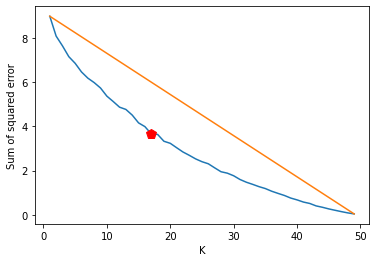

Retrieval complete. Total time: 3.9 minutes


In [8]:
root = Tk()
root.title('Preprint summarizer')
root.geometry('1530x900')
root.grid_propagate(False)

old_searches = []
for file in os.listdir('processed_texts/'):
    if file.endswith('.df'):
        old_searches.append(file[:-3])
        
l3_string = StringVar(value='')
l4_string = StringVar(value='')
url_string = StringVar(value='')

#################################################################################
# Setting up the main frames:
mainframe = Frame(root)
mainframe.pack(expand=True, fill=BOTH, padx=25, pady=10, anchor=NW)

topframe = Frame(mainframe)
topframe.pack(side=TOP, anchor=NW, expand=False, fill=X)

botframe = Frame(mainframe)
botframe.pack(side=BOTTOM, anchor=NW, expand=True, fill=Y, pady=2)

topleftframe = Frame(topframe)
topleftframe.pack(side=LEFT, anchor=NW, expand=False)

botleftframe = Frame(botframe)
botleftframe.pack(side=LEFT, anchor=NW, expand=True, fill=Y)

botrightframe = Frame(botframe)
botrightframe.pack(side=RIGHT, anchor=NW, expand=True, fill=Y, padx=15)
##################################################################################

# Labels, buttons, and search boxes:
l0 = Label(topleftframe, text = "Website:")
l0.grid(row = 1, column = 1, sticky = W)

sites = ttk.Combobox(topleftframe, height=1, width=35)
sites['values'] = ['biorxiv','medrxiv']
sites.current(0)
sites.grid(row = 1, column = 2, sticky = W, pady=2, padx=2)

l1 = Label(topleftframe, text = "Search:")
l1.grid(row = 1, column = 3, sticky = W)

searchfield = Entry(topleftframe, width=38)
searchfield.grid(row = 1, column = 3, sticky = W, padx=2)

searchbtn = Button(topleftframe, text='Search', command=get_num_results)
searchbtn.grid(row = 1, column = 4, sticky = W)

collectbtn = Button(topleftframe, text='Retrieve', command=search)
maxresults = ttk.Combobox(topleftframe, height=1, width=15)

l2 = Label(topleftframe, text = "Past searches:")
l2.grid(row = 2, column = 1, sticky = W)

searches = ttk.Combobox(topleftframe, height=1, width=35)
searches['values'] = old_searches
searches.bind("<<ComboboxSelected>>", oldsearches)
searches.grid(row = 2, column = 2, sticky = W, pady=2)

l3 = Label(topleftframe, textvariable=l3_string)
l3.grid(row = 1, column = 5, sticky = W, padx=5, pady=2)

l4 = Label(topleftframe, textvariable=l4_string)
l4.grid(row = 2, column = 3, sticky = W, padx=5, pady=2)


#####################################################
# Treeview:
s = ttk.Style()
s.configure('Treeview',rowheight=78)
s.configure('Treeview.Heading', font=(None, 10))
s.map('Treeview', background=[('selected','blue')])

tree = ttk.Treeview(botleftframe)
tree.bind("<Double-Button-1>", on_double_click)

tree.tag_configure('parent', background='white', font=(None, 10, 'italic'))
tree.tag_configure('oddrow', background='white')

tree['columns'] = ('Average Sentence', 'Authors', 'Date', 'Title')

tree.column('#0', width=50, minwidth=25)
tree.column('Average Sentence', anchor=W, width=480)
tree.column('Authors', anchor=W, width=100)
tree.column('Date', anchor=W, width=70)
tree.column('Title', anchor=W, width=250)

tree.heading('#0', text='Cluster', anchor=W)
tree.heading('Average Sentence', text='Average Sentence', anchor=W)
tree.heading('Authors', text='Authors', anchor=W)
tree.heading('Date', text='Date', anchor=CENTER)
tree.heading('Title', text='Title', anchor=W)

tree.pack(side=LEFT, expand=True, fill=BOTH, anchor=NW, pady=2)

textcanvas = Canvas(botrightframe, background='white', relief='groove', bd=1)
textcanvas.pack(expand=True, fill=BOTH, anchor=NW)

titletext= Text(textcanvas, bd=0, height=6)
titletext.tag_configure('title', font=(None, 11, 'italic'))
titletext.bind('<Double-Button-1>', on_web_click)
titletext.pack(side=TOP, expand=False, fill=X, anchor=NW, padx=10, pady=5)

bodytext = Text(textcanvas, bd=0)
bodytext.tag_configure('body', font=(None, 10))
bodytext.tag_configure('heading', font=(None, 11))
bodytext.pack(side=LEFT, expand=True, fill=BOTH, anchor=NW, padx=10, pady=5)

root.mainloop()